# Interacting Particle System with SIR Dynamics

In [1]:
from scipy.integrate import odeint
import scipy.special as math
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import itertools
from time import time as tm
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pylab import *

## Function definitions

In [2]:
def SIR(y,t,beta,gamma,N):
    S = y[0]
    I = y[1]
    R = y[2]
    dS_dt = -beta * I * S/N 
    dI_dt = beta * I * S/N - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def dist(y):
    return [zip(x,y) for x in itertools.permutations(y,len(y))]

# define the 1D spatial kernel
def d(y_i,y_j,sig):
    return np.exp(-np.mod(y_i-y_j,2)**2/(2*sig**2))#* 1/np.sqrt(2*np.pi * sig**2)

#volume of a ball of radius R in d dimensions
def V_ball(R,d):
    return np.pi**(d/2.0)* R**d / math.gamma(d/2.0+1)

#radius of a ball of volume V in d dimensions
def R_ball(V,d):
    return (math.gamma(d/2.0+1) / np.pi**(d/2.0) * V)**(1.0/d)

# calculate shortest directed distance towards/from a point on a circle of length L (for 1D sim)
def circ_dist(y,y0,L):
    ydrift = y0-y
    ydrift2 = np.sign(-ydrift) * (L-abs(ydrift))
    c = (abs(ydrift) > L/2.0)
    ydrift[c] = ydrift2[c]
    return ydrift

def d_torus(y,y0,L):
    ydrift = y0-y
    ydrift2 = np.sign(-ydrift) * (L-abs(ydrift))
    c = (abs(ydrift) > L/2.0)
    ydrift[c] = ydrift2[c]
    return ydrift

def w(y,s,r):
    ret = np.exp(-(d_torus(y,np.transpose(y)))**2/(2*r**2))
    ret[:,(s != 1)] = 0
    np.fill_diagonal(ret,0)
    return np.sum(ret,1)

# plotting 1D trajectories against time
def plot_trajectories(y,s,t,L):
    plt.figure()
    ax = plt.axes()
    for n in range(N):
        yp = y[n,:]
        sp = s[n,:]
        plt.scatter(t, yp, s=20, c=s[:,i])
    ax.autoscale_view()
    plt.ylim(0, L)
    plt.xlim(0,np.max(t))
    plt.xlabel("time")
    plt.ylabel("1d space")
    plt.show()
    
# plot state densities
def plot_densities(s_stat,N,sigma,theta,r,IT,D):
    im = plt.figure()
    plt.style.use('ggplot')
    for state in range(3):
        plt.plot(t,np.mean(np.mean(s_stat[:,:,:]==state,1),0),linewidth=2,color=co[state])
    for it in range(IT):
        plt.plot(t,np.mean(s_stat[it,:,:]==1,0),linewidth=.3)
    plt.xlabel("time")
    plt.ylabel("state density")
    plt.title(f"D = {D}, N = {N}, s^2/t = {round(sigma**2/theta,3)}, r = {r}, {IT} trials")
    plt.show()
    
# Poisson noise for SIR SDE - transitions from I -> R
def poisson_R(s, gamma): 
    gamma_v = np.ones(len(s))*gamma
    gamma_v[(s != 1)] = 0
    return np.random.poisson(lam=gamma_v,size=len(s))

# Poisson noise for SIR SDE - transitions from S -> I
def poisson_I(s, y, beta, r):
    beta_v = beta*w(y,s,r)
    beta_v[(s != 0)] = 0
    return np.random.poisson(lam=beta*w(y,s,r),size=len(s))

# 2D spatial kernel definition
def d_2D(y_i,y_j,sig):
    return np.exp(-(sum(np.mod(y_i[l]-y_j[l],L)**2 for l in range(len(y_i))))/(2*sig**2))

# color dictionary for plotting
colourdict = {0: [79/255,147/255,196/255], # Blue
             1: [1,149/255,58/255],  # Red
             2: [70/255,170/255,70/255]}  # Green

## Non-spatial SIR model (ODE)

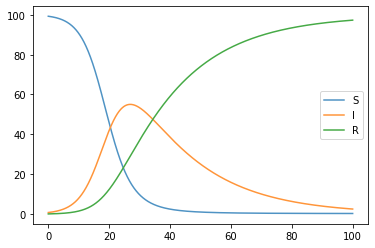

In [4]:
# Parameters
beta = 0.3
gamma=1/21   # recovery rate: time  it takes to recover from the disease and stop being contagious
N = 100
T=100;
dt=0.01;
N_times=np.int(T/dt)
N_infected=0.007*N

y0 = [N-N_infected,N_infected,0]
t = np.linspace(0,T,N_times) 
args = (beta,gamma,N)
res = odeint(SIR,y0,t,args)

plt.plot(t,res[:,0],label="S", c = (79/255,147/255,196/255))
plt.plot(t,res[:,1],label="I", c = (1,149/255,58/255))
plt.plot(t,res[:,2],label="R", c = (70/255,170/255,70/255))
plt.legend()
plt.show()


## Spatial SIR Model Simulation - 1D space

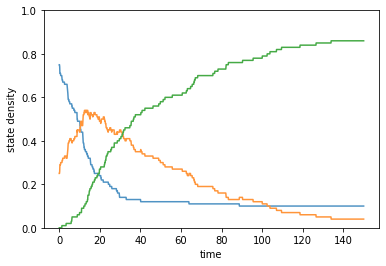

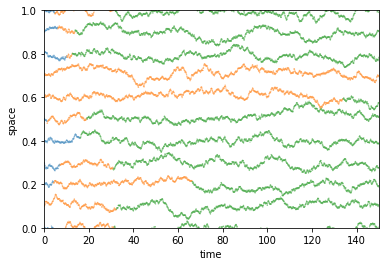

In [5]:
# Parameters
N = 10
L = 1
t_end = 150;
length = 1500
t = np.linspace(0,t_end,length) 
dt = np.mean(np.diff(t))
y = np.zeros((N,length))
s = np.zeros((N,length))

theta  = 0.1
sigma = 0.01 # OU variance parameter
r = 2 # stdev of Gaussian kernel
beta = 0.25 *dt/N
gamma = 0.025 *dt
prop_infected = 0.15

drift = lambda y,y0: (y0-y) 
diffusion = lambda y: sigma    

multi_mean = np.zeros(N)
multi_cov = np.diag(np.ones(N))

poisson_R = lambda n, s, gamma: np.random.poisson(lam=gamma) if s[n]==1 else 0
poisson_I = lambda n, s, y, beta: np.random.poisson(lam=beta*sum([d(y[n],y[m],r) for m in range(len(y)) if s[m]==1 and n!=m])) if s[n]==0 else 0 
I, R = 1, 2

IT = 10
s_stat = np.zeros((IT,N,length))
for it in range(IT):
    noise = np.random.multivariate_normal(mean=multi_mean,cov=multi_cov,size=length)*np.sqrt(dt) #define noise process
    y = np.zeros((N,length))
    s = np.zeros((N,length))
    y0 = np.linspace(1/N,1,N) 
    #y0 = np.random.uniform(low=0,high=L,size=N)
    s_p = np.random.rand(N)
    y[:,0] = y0
    s[:,0] = [np.int(s_p[i]<prop_infected) for i in range(N)]
    s[0,0] = 1
    for i in range(1,length):
        y[:,i] = y[:,i-1] + theta * circ_dist(y[:,i-1],y[:,0],L)*dt + diffusion(y[:,i-1])*noise[i]
        y[:,i] = np.mod(y[:,i],L)
        for n in range(N):
            s[n,i] = s[n,i-1] + drift(s[n,i-1],I)*poisson_I(n,s[:,i-1],y[:,i-1],beta) + drift(s[n,i-1],R)*poisson_R(n,s[:,i-1],gamma)
    s_stat[it,:,:]=s[:,:]

for state in range(3):
    plt.plot(t,np.mean(s_stat[:,:,:]==state,(0,1)), c = colourdict[state]) 
plt.xlabel("time")
plt.ylabel("state density")
plt.ylim(0, 1)
plt.show()

# plot a single simulation
for n in range(N):
    yp = y[n,:]
    sp = s[n,:]
    s_rgb = [colourdict[number] for number in sp]
    plt.scatter(t, yp, s=0.05, c=s_rgb)
    
#plt.scatter(tile(t, (N, 1)), y, s=0.05, c=s_rgb) 
plt.ylim(0, L)
plt.xlim(0,np.max(t))
plt.xlabel("time")
plt.ylabel("space")
plt.show()

## 2D Spatial SIR Model with movie

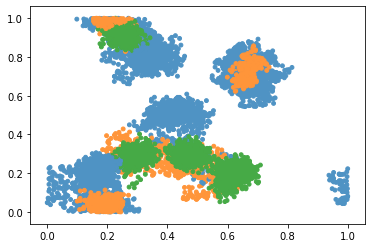

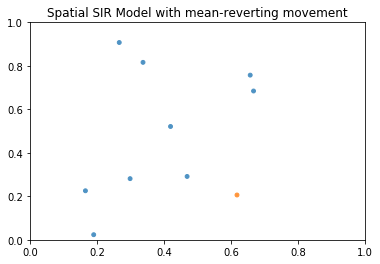

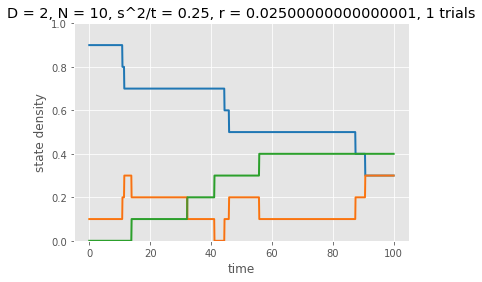

Time: 47.6


In [6]:
# Parameters
D = 2 # dimensions
t_end=100
length = 1000
t = np.linspace(0,t_end,length) 
dt = np.mean(np.diff(t)) 
L = 1
N = 10            

def plot_trajectories(y,s,t,N,step_sample):
    plt.figure()
    ax = plt.axes()
    for n in range(0,N,step_sample):
        yp = y[n,0,:]
        sp = s[n,:]
        segments_t = np.r_[t[0], t[1:-1].repeat(2), t[-1]].reshape(-1, 2)
        segments_y = np.r_[yp[0], yp[1:-1].repeat(2), yp[-1]].reshape(-1, 2)
        segments_s = np.r_[sp[0], sp[1:-1].repeat(2), sp[-1]].reshape(-1, 2)
        linecolors = [co[int(s[n,i])] for i in range(length)] #[co[0] if s_[0] == 0 and s_[1] == 0 else co[1] for s_ in segments_s]
        segments = [np.column_stack([t_, y_]) for t_, y_ in zip(segments_t, segments_y)]
        ax.add_collection(LineCollection(segments, colors=linecolors))
    ax.autoscale_view()
    #plt.ylim((y[0,0]+(2*L/N),y[0,0]-2*L/N))
    #plt.xlim((0,t_end))
    plt.title(f"trajectories, {np.int(N/step_sample)} samples")
    plt.xlabel("time")
    plt.ylabel("1d space")
    plt.show()
    
def plot_densities(s_stat,N,sigma,theta,r,IT,D):
    im = plt.figure()
    plt.style.use('ggplot')
    for state in range(3):
        plt.plot(t,np.mean(np.mean(s_stat[:,:,:]==state,1),0),linewidth=2,color=co[state])
    for it in range(IT):
        plt.plot(t,np.mean(s_stat[it,:,:]==1,0),linewidth=.3)
    plt.xlabel("time")
    plt.ylabel("state density")
    plt.title(f"D = {D}, N = {N}, s^2/t = {round(sigma**2/theta,3)}, r = {r}, {IT} trials")
    plt.ylim((0,1))
    plt.show()

c = mcolors.TABLEAU_COLORS
co = [c['tab:blue'],c['tab:orange'],c['tab:green'],c['tab:orange']]

def SDEint(N,D,dt,length,args):
    theta, sigma = args[0], args[1]
    diffusion, drift_y = args[2], args[3]
    alpha, beta, gamma = args[4], args[5], args[6]
    drift_s, poisson_I, poisson_R = args[7], args[8], args[9]
    
    noise = np.random.multivariate_normal(mean=multi_mean,cov=multi_cov,size=length)*np.sqrt(dt) #define noise process
    noise = noise.reshape((N,D,length))  

    y0, y = np.random.uniform(low=0,high=L,size=(N,D)), np.zeros((N,D,length))
    y[:,:,0] = y0
    
    s, s_pInf = np.zeros((N,length)), np.random.rand(N)
    s[:,0] = [np.int(s_pInf[i]<prop_infected) for i in range(N)]
    s[0,0] = 1

    for i in range(1,length):
        y[:,:,i] = y[:,:,i-1] + theta * drift_y(y[:,:,i-1],y[:,:,0])*dt + diffusion(y[:,:,i-1], sigma)*noise[:,:,i]
        y[:,:,i] = np.mod(y[:,:,i],L)
        s[:,i] = s[:,i-1] + drift_s(s[:,i-1],I)*poisson_I(s[:,i-1],y[:,:,i-1],alpha,beta,r) + drift_s(s[:,i-1],R)*poisson_R(s[:,i-1],gamma)
    return y, s

def d_torus(y,y0):
    ydrift = y0-y
    ydrift2 = np.sign(-ydrift) * (L-abs(ydrift))
    c = (abs(ydrift) > L/2.0)
    ydrift[c] = ydrift2[c]
    return ydrift

def w(y,s,r,N,D):
    d_2 = 0
    for n in range(D):
        y_coord = y[:,n].reshape((N,1))
        d_2 += d_torus(y_coord,y_coord.T)**2
    ret = np.exp(-d_2/(2*r**2))
    ret[:,(s != 1)] = 0
    np.fill_diagonal(ret,0)
    return np.sum(ret,1)

def poisson_R(s,gamma): 
    gamma_v = np.ones(len(s))*gamma
    gamma_v[(s != 1)] = 0
    return np.random.poisson(lam=gamma_v)

def poisson_I(s,y,alpha,beta,r,N,D):
    beta_v = beta*w(y,s,r,N,D) + alpha
    beta_v[(s != 0)] = 0
    return np.random.poisson(lam=beta_v)

drift_y = lambda y, y0: d_torus(y,y0)
drift_s = lambda s, s0: s0-s 
diffusion = lambda y, sigma: sigma 

    
S, I, R = 0, 1, 2

gamma = 1/21 *dt
prop_infected = .1
start_time = tm()
for sigma in [0.05]:
    sim_time = tm()
    theta  = np.linspace(0.01,2,length)
    r = R_ball(.05,1)
    alpha = 0.03 *dt /N
    beta = 20 *dt / N
    
    multi_mean = np.zeros(N*D)
    multi_cov = np.diag(np.ones(N*D))

    y = np.zeros((N,D,length))
    s = np.zeros((N,length))
    
    IT = 1
    s_stat = np.zeros((IT,N,length))
    for it in range(IT):            #run several (IT) iterations 
        
        noise = np.random.multivariate_normal(mean=multi_mean,cov=multi_cov,size=length)*np.sqrt(dt) #define noise process
        noise = noise.reshape((N,D,length))  

        y0 = np.random.uniform(low=0,high=L,size=(N,D))  
        y[:,:,0] = y0
        
        s_p = np.random.rand(N)
        s[:,0] = [np.int(s_p[i]<prop_infected) for i in range(N)]
        s[0,0] = 1
        
        for i in range(1,length):
            y[:,:,i] = y[:,:,i-1] + theta[i] * drift_y(y[:,:,i-1],y[:,:,0])*dt + diffusion(y[:,:,i-1], sigma)*noise[:,:,i]
            y[:,:,i] = np.mod(y[:,:,i],L)
            s[:,i] = s[:,i-1] + drift_s(s[:,i-1],I)*poisson_I(s[:,i-1],y[:,:,i-1],alpha,beta,r,N,D) + drift_s(s[:,i-1],R)*poisson_R(s[:,i-1],gamma)
            s_rgb = [colourdict[number] for number in s[:,i]]
            plt.scatter(y[:,0,i],y[:,1,i], s=15, c = s_rgb)
        
        s_stat[it,:,:]=s[:,:]
        
        ## Create Animation
        fig = plt.figure()
        ax = fig.subplots()
        # Initial Frame: 
        scat = ax.scatter(y[:,0,0], y[:,1,0], s=15)
        plt.title("Spatial SIR Model with mean-reverting movement")
        plt.xlim(0, L)
        plt.ylim(0, L)
        
        # Frame updated in the movie
        def update_img(frame_n):
            data = np.c_[y[:,0,frame_n], y[:,1,frame_n]]
            scat.set_offsets(data[:,:2])
            s_rgb = [colourdict[number] for number in s[:,frame_n]]
            scat.set_facecolor(np.asarray(s_rgb))
            return scat,

        ani = animation.FuncAnimation(fig, update_img, length, interval=30)

        writer = animation.writers['ffmpeg'](fps=24)
        ani.save('SIR_movie_merge.mp4',writer=writer,dpi=200)
        
    plot_densities(s_stat,N,sigma,theta[0],r,IT,D)
    print(f"Time: {round(tm()-sim_time,1)}")    